## Data Info

########################################

The ExtraSensory Dataset

Primary data files (features and labels)

########################################

The ExtraSensory Dataset was collected by
Yonatan Vaizman and Katherine Ellis, with the supervision of Gert Lanckriet.
Department of Electrical and Computer Engineering,
University of California, San Diego.

The dataset is publicly available.
Any usage of the dataset for publications requires citing the official paper that introduced the dataset:
Vaizman, Y., Ellis, K., and Lanckriet, G. "Recognizing Detailed Human Context In-the-Wild from Smartphones and Smartwatches".
IEEE Pervasive Computing, vol. 16, no. 4, October-December 2017, pp. 62-74. doi:10.1109/MPRV.2017.3971131
(In the website, we refer to this original paper as Vaizman2017a)

########################################

Content of the primary data files:
There are 60 'csv.gz' files, one for each participant (user, subject) in the data collection.
Each of these files has filename with the form:
[UUID].features_labels.csv.gz
where each user has a unique (randomly generated) universal user identification (UUID) number.
Each file is a textual CSV file, compressed using the gzip format.

Within every user's CSV file:
-----------------------------
- The first row specifies the columns of the file.
- Every other row refers to an example from the user. The examples are sorted according to the primary key - the timestamp.
- The columns:

-- First column is 'timestamp'. This is represented as standard number of seconds since the epoch.

-- Second, come columns for the extracted features.
   Unavailable features are represented with 'nan'.
   The name of each feature contains reference to the sensor it was extracted from, in the form [sensor_name]:[feature_name].
   The current version contains features from the following sensors, with sensor names:
--- raw_acc: Accelerometer from the phone. The 'raw' version of acceleration (as opposed to the decomposed versions of gravity and user-acceleration).   
--- proc_gyro: Gyroscope from the phone. Processed version of gyroscope measurements (the OS calculates a version that removes drift).
--- raw_magnet: Magnetometer from the phone. Raw version (as opposed to bias-fixed version that the OS also provides).
--- watch_acceleration: Accelerometer from the watch.
--- watch_heading: Heading from the compass on the watch.
--- location: Location services. These features were extracted offline for every example from the sequence of latitude-longitude-altitude updates from the example's minute.
              These features regard only to relative-location (not absolute location in the world) - meaning, they describe variability of movement within the minute.
--- location_quick_features: Location services. These features were calculated on the phone when data was collected. 
                             These are available even in cases that the other location features are not because the user wanted to conceal their absolute location coordinates.
							 These quick features are very simple heuristics that approximate the more thoughtful offline features.
--- audio_naive: Microphone. These naive features are simply averages and standard deviations of the 13 MFCCs from the ~20sec recording window of every example.
--- discrete: Phone-state. These are binary indicators for the state of the phone.
              Notice that time_of_day features are also considered phone-state features (also have prefix 'discrete:'), but their columns appear not right after the other 'discrete' columns.
--- lf_measurements: Various sensors that were recorded in low-frequency (meaning, once per example).

-- Third, come columns for the ground truth labels.
   The values are either 1 (label is relevant for the example), 0 (label is not relevant for the example), or 'nan' (label is considered 'missing' for this example).
   Originally, users could only report 'positive' labels (in the original ExtraSensory paper, Vaizman2017a, we assumed that when a label was not reported it is a 'negative' example).
   This cleaned version of the labels has the notion of 'missing labels'; Details about how we inferred missing label information is provided in the second paper, Vaizman2017b (see http://extrasensory.ucsd.edu for updated references).
   The names of the labels have prefix 'label:'. After the prefix:
   If the label name is all capitalized, it is an original label from the mobile app's interface and the values were taken from what the user originally reported.
   If the label name begins with 'FIX_', this is a fixes/cleaned version of a corresponding label, meaning that the researchers fixed some of the values that were reported by users because of inconsistencies.
   If the label name begins with 'OR_', this is a synthesized label, meaning it did not appear in the app's label menu, but rather the researchers created it as combination (using logical or) of other related labels.
   If the label name begins with 'LOC_', this is a fixed/cleaned version of a corresponding label that was fixed by researchers based on absolute location.
      LOC_beach was based on original label 'AT_THE_BEACH'.
	  LOC_home was based on original label 'AT_HOME'.
	  LOC_main_workplace was based on original label 'AT_WORK'.

-- Fourth, the last column is label_source, describing where the original labeling came from in the mobile app's interface. It has 8 possible values:
   -1: The user did not report any labels for this example (notice, however, that this example may still have labeling for the 'LOC_' labels).
   0 : The user used the 'active feedback' interface (reporting immediate future). This example is the first in relevant minute sequence.
   1 : The user used the 'active feedback' interface. This example is a continuation of a sequence of minutes since the user started the reported context.
   2 : The user used the history interface to label an example from the past.
   3 : The user replied to a notification that simply asked to provide any labels.
   4 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the phone.
   5 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'not exactly' and then corrected the context labels.
   6 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the watch interface.


########################################

## Data Consolidation
Getting the data from all the different files into one csv.

In [1]:
import zipfile
import os
import gzip
import shutil
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns



/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_86344/3409454130.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import load_model, clone_model


import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# Making sure ExtraSensory.per_uuid_features_labels.zip exists and is unziped

def unzip(zip_file):
    # Extract to the directory obtained from the zip file name
    zip_extract_to = zip_file.replace('.zip', '')

    # Unzipping
    if os.path.exists(zip_file):
        if not os.path.exists(zip_extract_to):
            os.makedirs(zip_extract_to)
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(zip_extract_to)
            message = "Unzipped successfully."
        else:
            message = "Directory already exists. File might be unzipped."
    else:
        message = "Zip file not found."

    print(message)
    return zip_extract_to


def csv_extract(zip_extract_to):
    # Improved variable name for the directory where the extracted files will be saved
    unzipped_data_dir = f"{zip_extract_to}-Unzipped"

    # Create the unzipped data directory if it does not exist
    if not os.path.exists(unzipped_data_dir):
        os.makedirs(unzipped_data_dir)

    # Extracting .csv.gz files
    extraction_message = ""
    if os.path.exists(zip_extract_to):
        for file in os.listdir(zip_extract_to):
            if file.endswith('.gz'):
                gz_file_path = os.path.join(zip_extract_to, file)
                csv_file_path = os.path.join(unzipped_data_dir, file[:-3])  # Removing '.gz' from filename

                try:
                    with gzip.open(gz_file_path, 'rb') as f_in:
                        with open(csv_file_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    extraction_message += f"Extracted {file}\n"
                except Exception as e:
                    extraction_message += f"Error extracting {file}: {e}\n"
    else:
        extraction_message = "Directory with .gz files not found."

    print(extraction_message.strip())

    return unzipped_data_dir


# Function to extract user_id from filename
def extract_user_id(filename):
    return filename.split('.')[0]

def make_one_csv(unzipped_data_dir, COMBINED_FILE):
    # Combining all CSVs into one dataframe
    combined_csv_data = pd.DataFrame()

    if os.path.exists(unzipped_data_dir):
        for file in os.listdir(unzipped_data_dir):
            if file.endswith('.csv'):
                file_path = os.path.join(unzipped_data_dir, file)
                user_id = extract_user_id(file)

                # Read the CSV file and add the user_id column
                csv_data = pd.read_csv(file_path)
                csv_data['user_id'] = user_id

                # Append to the combined dataframe
                combined_csv_data = pd.concat([combined_csv_data, csv_data], ignore_index=True)

                
                #print(f"Processed file: {file} \nCurrent size of combined data: {combined_csv_data.shape}")


        # Check if any data has been combined
        if not combined_csv_data.empty:
            # Save the combined CSV data to a file
            combined_csv_data.to_csv(COMBINED_FILE, index=False)
            print(f"Combined CSV file created at {COMBINED_FILE}.")
        else:
            print("No CSV files found to combine or combined data is empty.")
    else:
        print("Directory with unzipped CSV files not found.")
    return COMBINED_FILE



In [5]:
COMBINED_FILE = 'ExtraSensory_Combined_User_Data.csv'
if not os.path.exists(COMBINED_FILE):
    # Path of the zip file
    zip_file = 'ExtraSensory.per_uuid_features_labels.zip'
    zip_extract_to = unzip(zip_file)
    unzipped_data_dir = csv_extract(zip_extract_to)
    make_one_csv(unzipped_data_dir, COMBINED_FILE)
else:
    print('Combined file already exists.')


Combined file already exists.


## Data Exploration

In [6]:
combined_csv_data = pd.read_csv(COMBINED_FILE)
combined_csv_data['timestamp'] = pd.to_datetime(combined_csv_data['timestamp'], unit='s')

In [7]:
print(combined_csv_data.columns)

# user_id is for us to make sure we have record on source of the data. 

Index(['timestamp', 'raw_acc:magnitude_stats:mean',
       'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3',
       'raw_acc:magnitude_stats:moment4',
       'raw_acc:magnitude_stats:percentile25',
       'raw_acc:magnitude_stats:percentile50',
       'raw_acc:magnitude_stats:percentile75',
       'raw_acc:magnitude_stats:value_entropy',
       'raw_acc:magnitude_stats:time_entropy',
       ...
       'label:ELEVATOR', 'label:OR_standing', 'label:AT_SCHOOL',
       'label:PHONE_IN_HAND', 'label:PHONE_IN_BAG', 'label:PHONE_ON_TABLE',
       'label:WITH_CO-WORKERS', 'label:WITH_FRIENDS', 'label_source',
       'user_id'],
      dtype='object', length=279)


In [8]:
# Trying to understand columns
def build_hierarchy(columns):
    # Build a nested dictionary representing the hierarchy of columns.
    hierarchy = {}
    for col in columns:
        parts = col.split(':')
        current_level = hierarchy

        for part in parts[:-1]:
            current_level = current_level.setdefault(part, {})
        
        current_level[parts[-1]] = col

    return hierarchy

def format_hierarchy(hierarchy, indent=0):
    # Format the hierarchy into a readable string with indentation.
    result = ""
    for key, value in hierarchy.items():
        prefix = "  " * indent + "- "
        if isinstance(value, dict):
            result += f"{prefix}{key}:\n{format_hierarchy(value, indent + 1)}"
        else:
            result += f"{prefix} {key}\n"
    return result

# Building and formatting the hierarchy
hierarchy = build_hierarchy(combined_csv_data.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

-  timestamp
- raw_acc:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  mean_y
    -  mean_z
    -  std_x
    -  std_y
    -  std_z
    -  ro_xy
    -  ro_xz
    -  ro_yz
- proc_gyro:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  me

In [9]:
# List of label columns to check
label_columns = [col for col in combined_csv_data.columns if col.startswith("label:")]

combined_csv_data[label_columns] = combined_csv_data[label_columns].fillna(0)

combined_csv_data['label_sum_inital'] = combined_csv_data[label_columns].sum(axis=1)
combined_csv_data['label:UNKNOWN'] = (combined_csv_data['label_sum_inital'] == 0).astype(float)
label_columns.append('label:UNKNOWN')
combined_csv_data = combined_csv_data.drop('label_sum_inital', axis=1)
df = combined_csv_data.copy()


# Function to find the label name with value 1
def find_label_name(row):
    for col in label_columns:
        if row[col] == 1:
            return col.split("label:")[1]
    return None



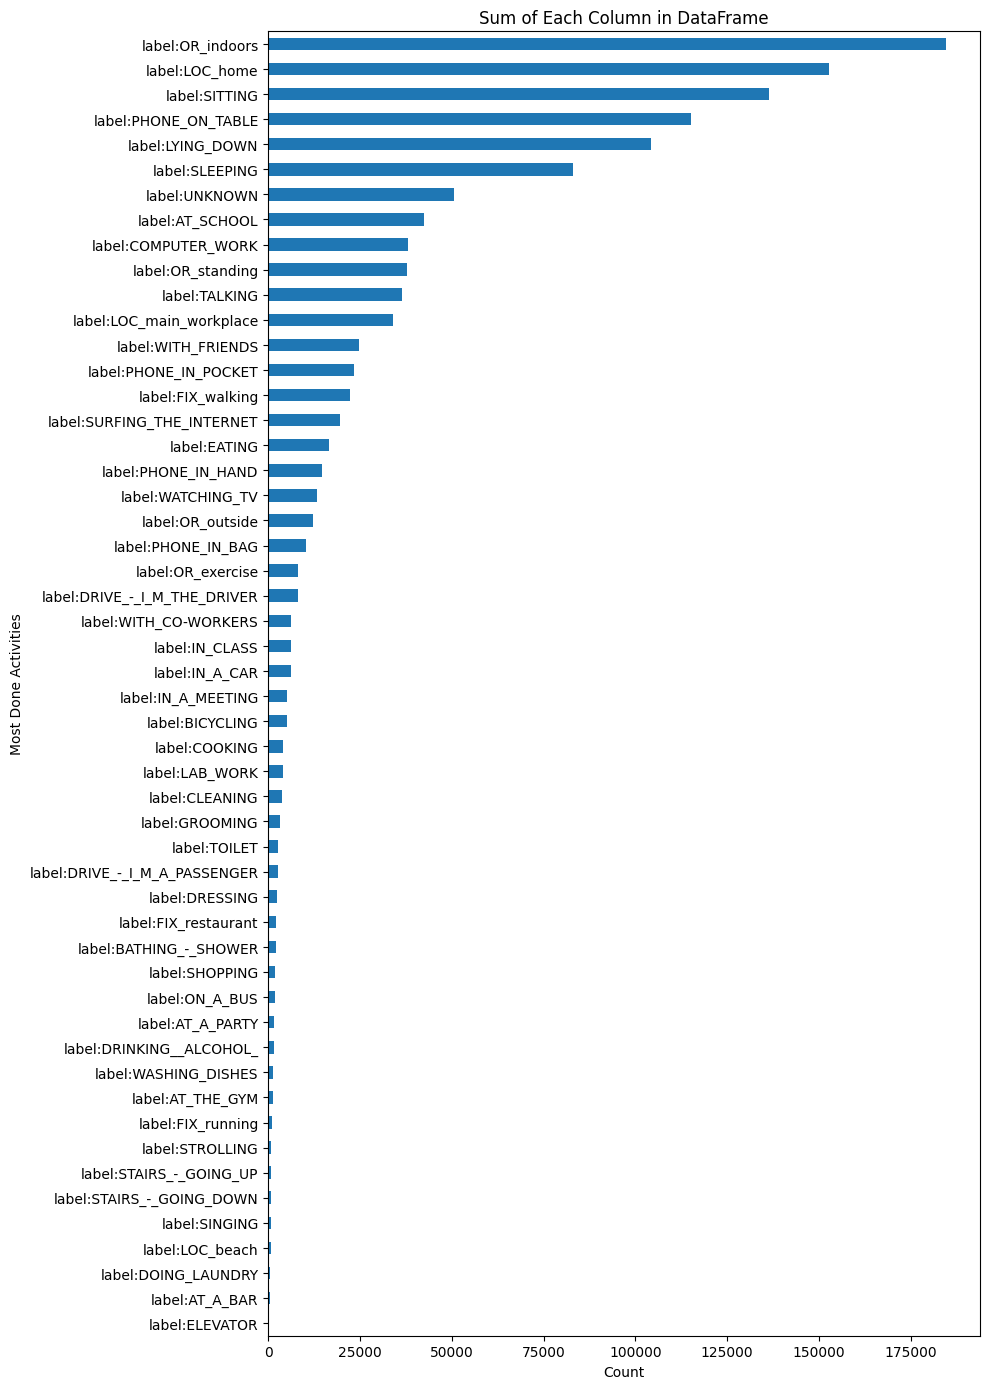

In [10]:
column_sums = df[label_columns].sum()
column_sums_sorted = column_sums.sort_values(ascending=True)

plt.figure(figsize=(10, 14)) 
column_sums_sorted.plot(kind='barh')

# Adding titles and labels for clarity
plt.title('Sum of Each Column in DataFrame')
plt.xlabel('Count')
plt.ylabel('Most Done Activities')

# Adjust layout to make room for the labels
plt.tight_layout()

# Display the plot
plt.show()

In [11]:
# Deleting the other columns
unneeded_columns = ['user_id', 'label_source']
output_columns = [col for col in combined_csv_data.columns if col.startswith('label:')]
input_columns = [col for col in combined_csv_data.columns if col not in output_columns and col not in unneeded_columns]
X_main = df.copy()[input_columns]

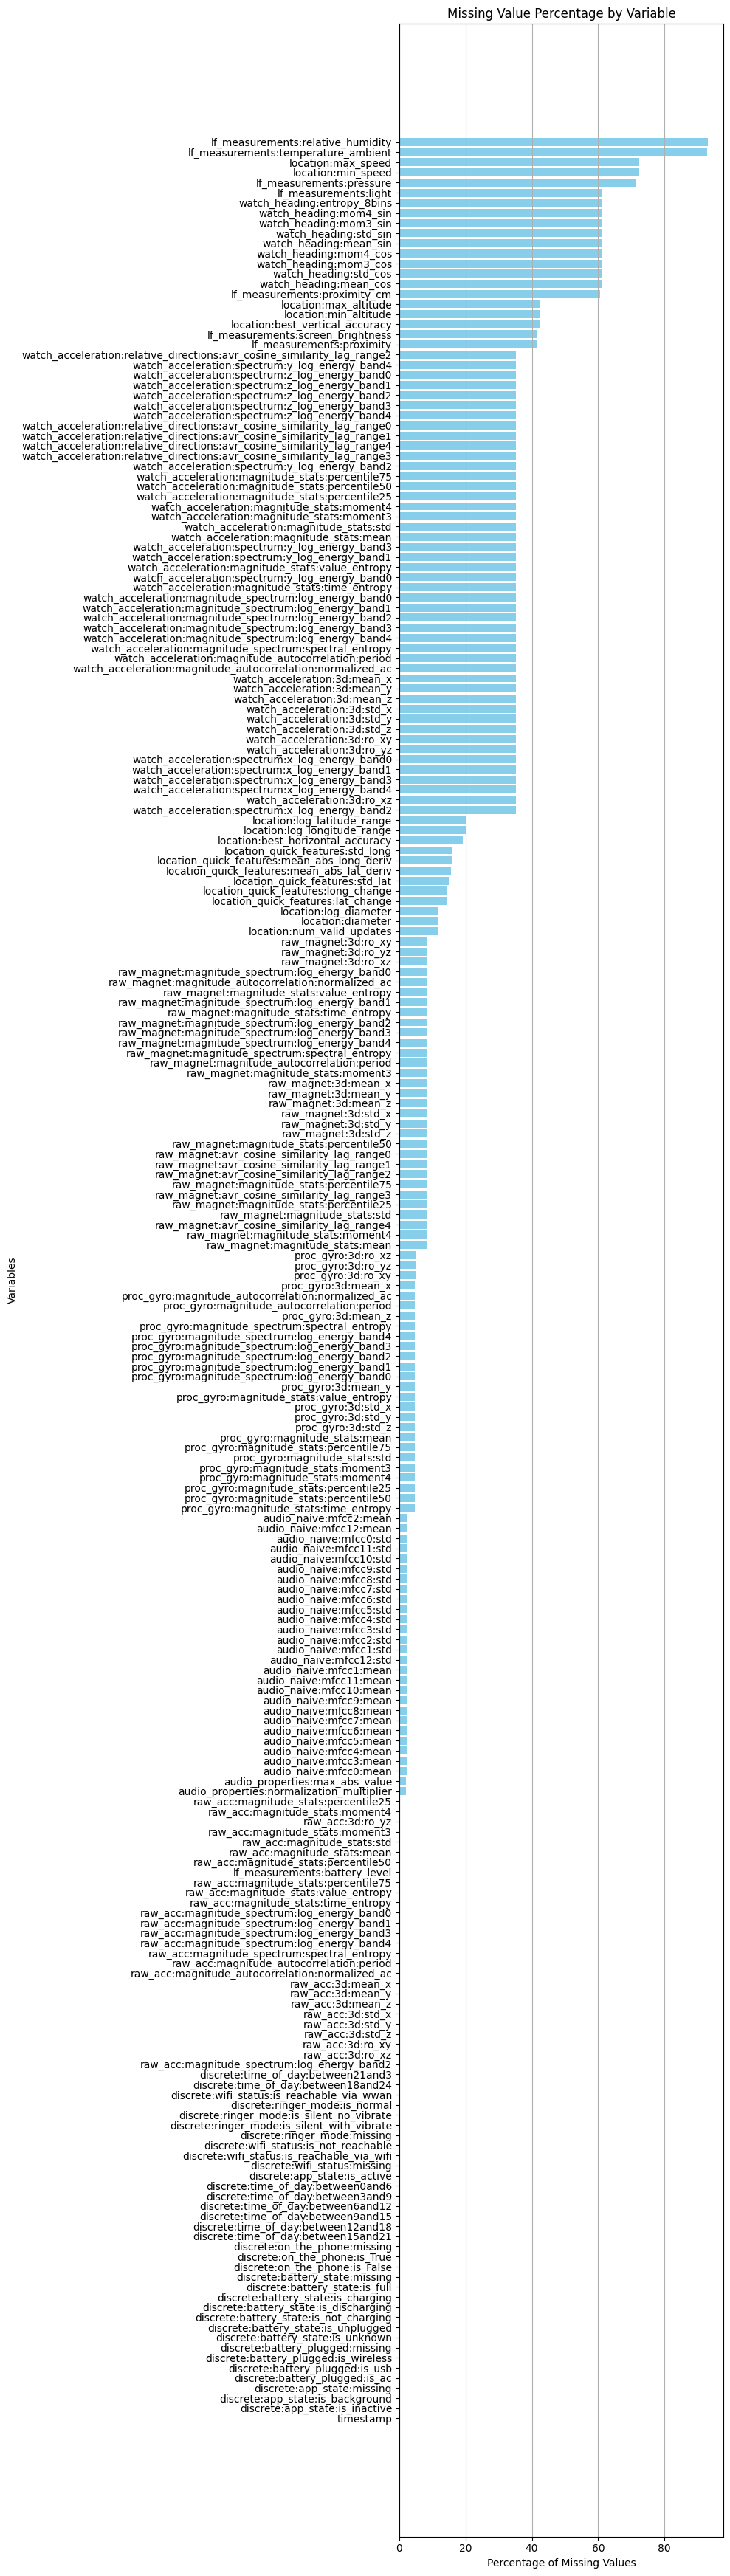

In [12]:
def nan_percentage(df):
    nan_percentage = (df.isna().mean() * 100).round(2)
    nan_percentage_df = pd.DataFrame({'Variable': nan_percentage.index, 'NaN Percentage': nan_percentage.values})
    nan_percentage_df = nan_percentage_df.sort_values(by='NaN Percentage', ascending=True)
    # print(nan_percentage_df)
    
    # Plot setup
    plt.figure(figsize=(10, 35)) 
    plt.barh(nan_percentage_df['Variable'], nan_percentage_df['NaN Percentage'], color='skyblue')
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Variables')
    plt.title('Missing Value Percentage by Variable')
    plt.grid(axis='x')

    # Improve readability
    plt.tight_layout()  # Adjust subplot parameters to give specified padding

    plt.show()
    return nan_percentage_df
# Checking overall missing percentage
nan_percentage_df = nan_percentage(X_main)


In [13]:
X_with_users = df.drop(columns=['label_source'])

In [14]:
users = X_with_users['user_id'].unique()
len(users)

60

In [15]:
features = input_columns

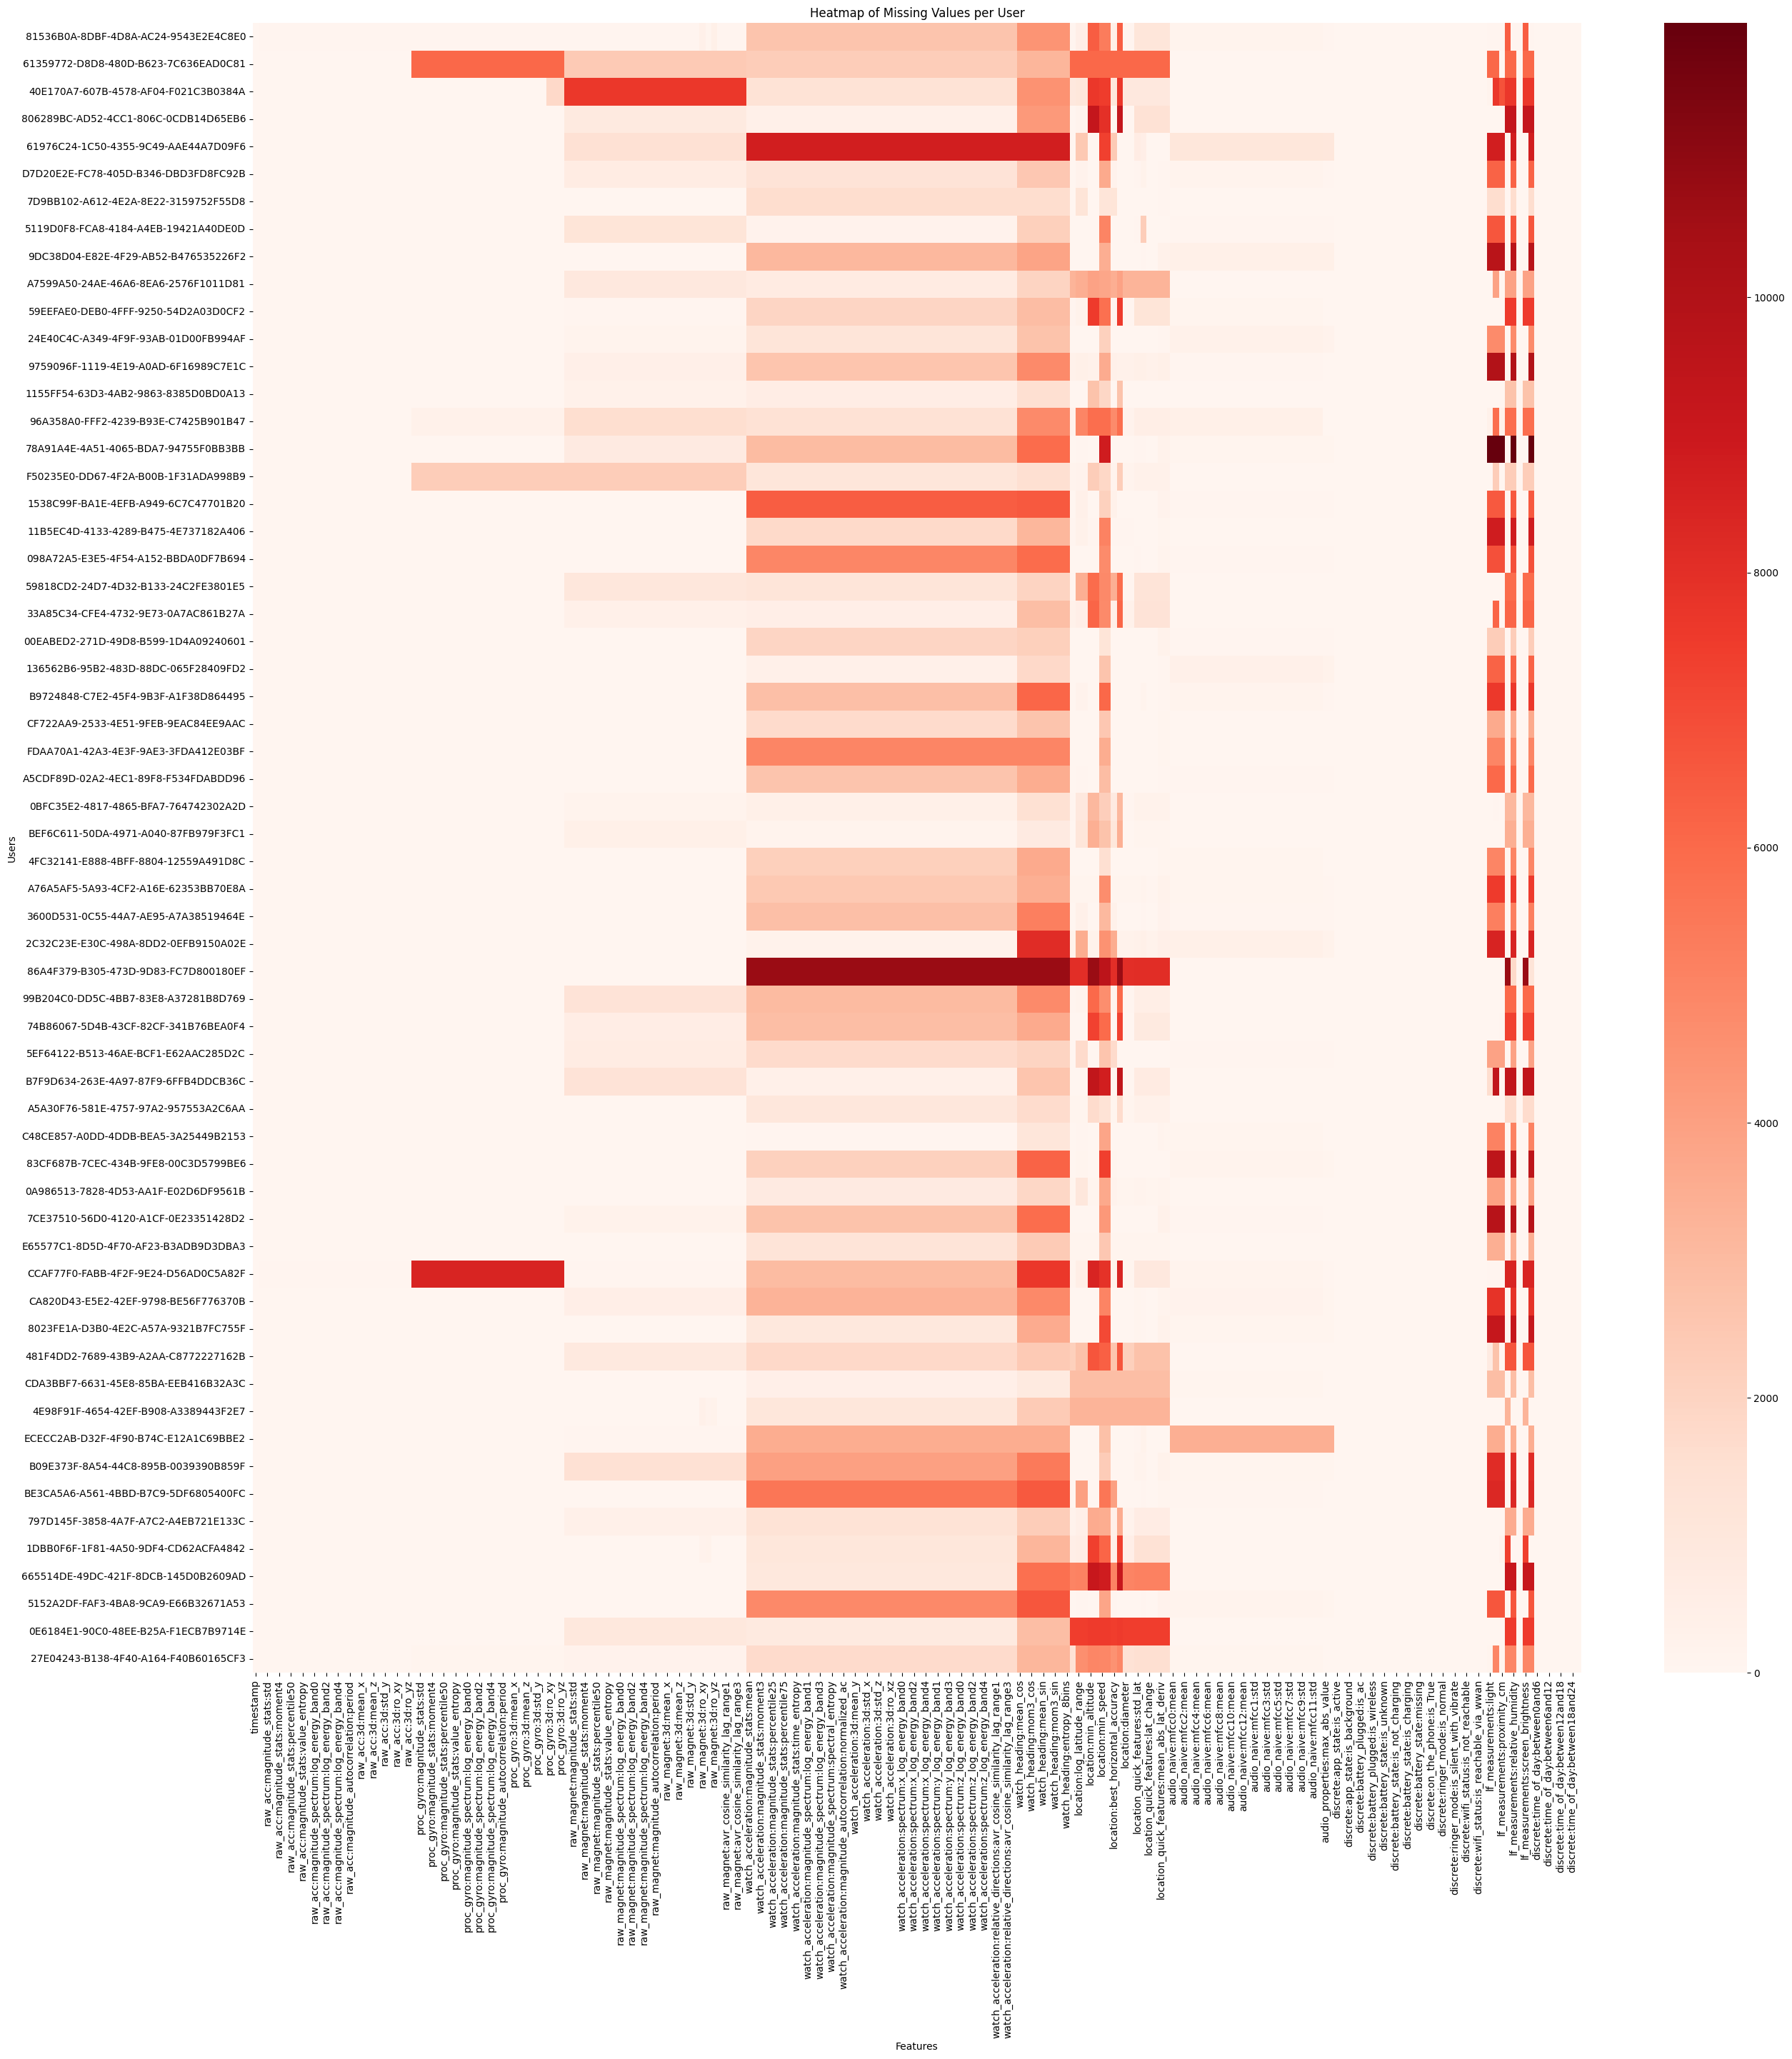

In [16]:
# Initialize a list to store the counts for each user
nan_counts_list = []

# Loop through each user
for user in users:
    # Filter the DataFrame for the current user
    df_user = X_with_users[X_with_users['user_id'] == user]
    
    # Count the NaN values for each feature for the current user and add user_id to the series
    nan_count = df_user[features].isna().sum()
    nan_count['user_id'] = user  # Add user_id to the count
    
    # Append the count series to the list
    nan_counts_list.append(nan_count)

# Convert the list of Series to a DataFrame
nan_counts_per_user = pd.DataFrame(nan_counts_list)

# If needed, set the user_id as the index
nan_counts_per_user.set_index('user_id', inplace=True)


# Plotting the heat map
plt.figure(figsize=(30, 30))
sns.heatmap(nan_counts_per_user, annot=False, cmap='Reds')
plt.title('Heatmap of Missing Values per User')
plt.xlabel('Features')
plt.ylabel('Users')
plt.show()

In [17]:
# Calculate the total number of rows for each user in the original DataFrame
user_total_length = X_with_users.groupby('user_id').size()

# Convert this to a DataFrame or a Series that can be added to nan_counts_per_user
user_total_length_df = user_total_length.to_frame(name='total_length')

# Merge this information with nan_counts_per_user
# Since nan_counts_per_user already has user_id as its index, we can directly add the new column
nan_counts_per_user['total_length'] = user_total_length_df['total_length']

# Now, nan_counts_per_user includes the total_length column


In [18]:

# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100


# Decide on a threshold for removing columns, e.g., 1%
threshold = 30

# Identify columns that exceed this threshold
columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

print("Removing ", len(columns_to_remove),"columns out of ", len(X_with_users.columns))
# Print out the columns to remove
# print("Columns to remove due to excessive missing data:", columns_to_remove)

features_to_include = [feature for feature in features if feature not in columns_to_remove]

if 'timestamp' in X_with_users.columns:
    X_with_users['timestamp_numeric'] = X_with_users['timestamp'].astype(np.int64) // 10**9
    # Ensure 'timestamp_numeric' is included and 'timestamp' is excluded from features_to_include
    features_to_include = [f for f in features_to_include if f != 'timestamp'] + ['timestamp_numeric']

# Continue with your existing preprocessing...
user_df = X_with_users[X_with_users['user_id'] == users[-1]]
median_values = user_df[features_to_include].median()
user_df = user_df[features_to_include].fillna(median_values)

# Scale features
from sklearn.preprocessing import MinMaxScaler

s1 = MinMaxScaler(feature_range=(-1,1))
user_df_scaled = s1.fit_transform(user_df)
user_df_scaled = pd.DataFrame(user_df_scaled, columns=features_to_include)

# Create sequences
look_back = 4
generator = TimeseriesGenerator(user_df_scaled.values, user_df_scaled.values,
                                length=look_back, batch_size=1)
def create_lstm_model(input_shape, num_features):
    model = Sequential([
        LSTM(units = num_features, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        Dense(num_features),
        LSTM(units=num_features, return_sequences=True),
        Dropout(0.2),        
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),        
        LSTM(units=num_features),
        Dense(num_features),
        Activation('linear'),
        
    ])
    model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])  
    return model
model_path = 'LSTM_next_model.h5'
# Define and compile the LSTM model
model = create_lstm_model((look_back, len(features_to_include)), len(features_to_include))

import keras
if os.path.exists(model_path):
    load_model(model_path)
else:

    model.fit(generator, epochs=1) 
    model.save(model_path)

Removing  68 columns out of  279


In [19]:
def predict_from_df(df, model, features_to_include, look_back=4):
    df_filtered = df[features_to_include]
    
    if len(df_filtered) >= look_back:
        # Extract the last `look_back` rows for the prediction
        last_sequences = df_filtered[-look_back:].values.reshape((1, look_back, len(features_to_include)))
    else:
        raise ValueError(f"DataFrame must have at least {look_back} rows for prediction.")
    
    # Predict the next row using the LSTM model
    predictions = model.predict(last_sequences)
    
    
    return predictions

def compare_predictions_with_actual(df, model, features_to_include, look_back=3):
    predictions = predict_from_df(user_df.iloc[1:5], model, features_to_include, look_back)
    predictions = s1.inverse_transform(predictions)
    actual_values = user_df.iloc[4][features_to_include].values  # Adjust index if needed
    
    return predictions, actual_values

# Assuming 'user_df' is already preprocessed appropriately, including scaling
predictions, actual_values = compare_predictions_with_actual(user_df, model, features_to_include, look_back=4)

# Now you can compare 'predictions' with 'actual_values'
# Note: If your data was scaled, you might need to inverse scale both predictions and actual values before comparison

print(f"{'Predictions':<15}   | {'Actual Values':<15} | {'Diff':<15} | {'Diff %':<15}")
print("-" * 47)  # Adjust the number based on the width of your columns

j = 0
for i in range(len(predictions[j])):
    p = predictions[j][i]
    a = actual_values[i]
    diff = a-p
    diff_p = ((p-a)/a)*100
    print(f"{p:.6f}{'':<9} | {a:<15} | {diff:.6f} | {diff_p:.6f}")



1/1 [==============================] - 1s 725ms/step
Predictions       | Actual Values   | Diff            | Diff %         
-----------------------------------------------
1.085335          | 0.992139        | -0.093196 | 9.393455
0.318196          | 0.008221        | -0.309975 | 3770.528134
0.175457          | -0.010007       | -0.185464 | -1853.338647
0.452432          | 0.017953        | -0.434479 | 2420.089062
0.837711          | 0.988784        | 0.151073 | -15.278674
1.020068          | 0.992739        | -0.027329 | 2.752846
1.254617          | 0.995041        | -0.259576 | 26.086999
1.508082          | 1.481067        | -0.027015 | 1.824001
6.614140          | 6.684577        | 0.070437 | -1.053724
4.989978          | 5.043079        | 0.053101 | -1.052951
1.522245          | 0.000594        | -1.521651 | 256170.230419
2.355121          | 0.00138         | -2.353741 | 170560.917310
1.825697          | 0.000869        | -1.824828 | 209991.749461
2.210595          | 0.013867     

/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_86344/1789851892.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  diff_p = ((p-a)/a)*100


# Testing CNN And LSTM for prediction

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])
# Assuming 'combined_csv_data' is your DataFrame
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

# Adjust the input shape according to your dataset
input_shape = (X_train.shape[1], 1)  # Assuming non-sequential data for simplicity

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Instead of Flatten, use Reshape or adjust the model so it's suitable for LSTM input
    # Reshape example (adjust the target shape according to your needs):
    # This line is illustrative; actual reshaping depends on the output shape of the previous layer
    Reshape((-1, 128)),  # Adjust the target shape
    LSTM(50, return_sequences=False),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label classification
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 157, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 78, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 38, 128)           0         
 g1D)                                                            
                                                                 
 reshape (Reshape)           (None, 38, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)               

In [22]:
# Reshape data for CNN if needed
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [23]:
# For arrays, assuming X_train_reshaped and y_train are your features and labels respectively
subset_size = 100  # Choose a small size for quick tests
X_train_subset = X_train_reshaped[:subset_size]
y_train_subset = y_train[:subset_size]


In [24]:
# Testing Shape Issues
model_name = 'first_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    history = model.fit(X_train, y_train,
                    epochs=1,  
                    batch_size=64, 
                    validation_split=0.2, 
                    verbose=1)  

    model.save(model_name)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Reshape, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Reshape((-1, 128)),  # Adjust based on the output shape of the previous layer
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.5),
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

model_name = 'second_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)
    model.save(model_name)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 157, 64)           256       
                                                                 
 batch_normalization (Batch  (None, 157, 64)           256       
 Normalization)                                                  
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 78, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 76, 128)           24704     
                                                                 
 batch_normalization_1 (Bat  (None, 76, 128)           512       
 chNormalization)                                                
                                                      

In [26]:
# Example fitting with callbacks
# model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Reshape, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Reshape((-1, 128)),  # Adjust based on the output shape of the previous layer
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.5),
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 157, 64)           256       
                                                                 
 batch_normalization_3 (Bat  (None, 157, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 78, 64)            0         
 g1D)                                                            
                                                                 
 reshape_2 (Reshape)         (None, 39, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               183200    
 onal)                                                           
                                                      

In [28]:
model_name = 'third_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)
    model.save(model_name)
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [29]:
model_name = 'third_try_2.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=20,  validation_split=0.2)
    model.save(model_name)
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

# Adjust the input shape according to your dataset
input_shape = (X_train.shape[1], 1)  # Assuming non-sequential data for simplicity

model = Sequential([
    LSTM(len(label_columns), return_sequences=True, input_shape=input_shape),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.2),
    Conv1D(filters=len(label_columns), kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=7),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Instead of Flatten, use Reshape or adjust the model so it's suitable for LSTM input
    # Reshape example (adjust the target shape according to your needs):
    # This line is illustrative; actual reshaping depends on the output shape of the previous layer
    Reshape((-1, 128)),  # Adjust the target shape
    LSTM(50, return_sequences=False),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label classification
              metrics=['accuracy'])

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 159, 52)           11232     
                                                                 
 dropout_7 (Dropout)         (None, 159, 52)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 158, 52)           5460      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 22, 52)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 20, 128)           20096     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 10, 128)           0         
 g1D)                                                 

In [32]:
model_name = 'fourth_try_2.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1, validation_split=0.2)
    model.save(model_name)

2024-02-13 04:25:35.116777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


7547/7547 [==============================] - 254s 33ms/step - loss: 0.1696 - accuracy: 0.0474 - val_loss: 0.1678 - val_accuracy: 0.0476


/Users/zaina/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
hierarchy = build_hierarchy(X.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## Testing Batch Sizes

In [ ]:

def find_best_batch_size(model, X_train, y_train, X_test, y_test, batch_sizes):
    """
    Trains a given model using different batch sizes, evaluates performance on test data,
    stores each trained model, and returns the best batch size along with its accuracy and a dictionary of models.

    Parameters:
    - model: The initial model to be trained.
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Test data and labels.
    - batch_sizes: List of batch sizes to test.

    Returns:
    - best_batch_size: The batch size yielding the highest accuracy on test data.
    - best_acc: The highest accuracy achieved on test data.
    - models_dict: A dictionary of saved model filenames keyed by their batch sizes.
    """
    models_dict = {}
    best_acc = 0
    best_batch_size = None

    for batch_size in batch_sizes:
        print(f"Training with batch size: {batch_size}")
        # Clone the original model architecture for a fair comparison
        model_clone = clone_model(model)
        model_clone.compile(optimizer=model.optimizer, loss=model.loss, metrics=model.metrics)
        
        # Fit the model
        model_clone.fit(X_train, y_train,
                        epochs=2, 
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=1)
        
        # Evaluate the model
        test_loss, test_acc = model_clone.evaluate(X_test, y_test, verbose=2)
        print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")
        
        # Save the model
        model_file_name = f'ExtraSensory_CNN_LSTM_bs{batch_size}.h5'
        model_clone.save(model_file_name)
        models_dict[batch_size] = model_file_name
        
        # Update best model if current is better
        if test_acc > best_acc:
            best_acc = test_acc
            best_batch_size = batch_size

    print(f"Best Batch Size: {best_batch_size} with Test Accuracy: {best_acc}")
    return best_batch_size, best_acc, models_dict

# Example usage:
batch_sizes = [128, 64, 16, 4, 1, None] 
# Call the function and store its return values
best_batch_size, best_acc, models_dict = find_best_batch_size(model, X_train_reshaped, y_train, X_test_reshaped, y_test, batch_sizes)

# Now `models_dict` is available outside of the function
print("Available models and their batch sizes:")
for batch_size, model_path in models_dict.items():
    print(f"Batch Size: {batch_size}, Model Path: {model_path}")

# You can load any model from `models_dict` for further use
# selected_model_path = models_dict[best_batch_size]
# loaded_model = load_model(selected_model_path)


In [212]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


2359/2359 - 13s - loss: 0.1687 - accuracy: 0.0472 - 13s/epoch - 6ms/step
Test accuracy: 0.04721081256866455, Test loss: 0.16865016520023346


In [ ]:
model.save('ExtraSensory_CNN_LSTM_Model_v2.h5')


In [210]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=10, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
3774/3774 [==============================] - 98s 26ms/step - loss: 0.1721 - accuracy: 0.0507 - val_loss: 0.1682 - val_accuracy: 0.0476
Epoch 2/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1692 - accuracy: 0.0539 - val_loss: 0.1683 - val_accuracy: 0.0476
Epoch 3/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1693 - accuracy: 0.0538 - val_loss: 0.1680 - val_accuracy: 0.0476
Epoch 4/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1693 - accuracy: 0.0554 - val_loss: 0.1680 - val_accuracy: 0.0476
Epoch 5/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1694 - accuracy: 0.0572 - val_loss: 0.1683 - val_accuracy: 0.0476
Epoch 6/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1695 - accuracy: 0.0586 - val_loss: 0.1682 - val_accuracy: 0.0476
Epoch 7/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1696 - accuracy: 0.0593 - val_loss: 0.1694 -

In [225]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=2, 
                    batch_size=20,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/2
12075/12075 [==============================] - 219s 18ms/step - loss: 0.1717 - accuracy: 0.0778 - val_loss: 0.1700 - val_accuracy: 0.0476
Epoch 2/2
12075/12075 [==============================] - 191s 16ms/step - loss: 0.1720 - accuracy: 0.0802 - val_loss: 0.1695 - val_accuracy: 0.0476


In [228]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


2359/2359 - 15s - loss: 0.1700 - accuracy: 0.0472 - 15s/epoch - 6ms/step
Test accuracy: 0.04721081256866455, Test loss: 0.16999678313732147


In [229]:
model.save('ExtraSensory_CNN_LSTM_Model_v2_bs_20.h5')


/Users/zaina/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [230]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=2, 
                    batch_size=2,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/2
 21579/120750 [====>.........................] - ETA: 22:30 - loss: 0.1824 - accuracy: 0.1195

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:
model.save('ExtraSensory_CNN_LSTM_Model_v2_bs_2.h5')


In [ ]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=2, 
                    validation_split=0.2,
                    verbose=1)
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')
model.save('ExtraSensory_CNN_LSTM_Model_v2_bs_1.h5')


## Testing Thresholds

In [89]:

# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100


def testing_threshold(threshold, testing_user, fill_type= 'ffill', epochs = 1 ):

    # Decide on a threshold for removing columns, e.g., 1%
    threshold = threshold

    # Identify columns that exceed this threshold
    columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

    print("Removing ", len(columns_to_remove),"columns out of ", len(X_with_users.columns))
    # Print out the columns to remove
    # print("Columns to remove due to excessive missing data:", columns_to_remove)

    features_to_include = [feature for feature in features if feature not in columns_to_remove]

    # First User 
    user_df = X_with_users[X_with_users['user_id'] == users[testing_user]]
    
    if fill_type == 'ffill':
    # Forward fill
        user_df = user_df[features_to_include].ffill()
    elif fill_type == 'mean':
        # Fill missing values with the mean of each column
        mean_values = user_df[features_to_include].mean()
        user_df = user_df[features_to_include].fillna(mean_values)
    elif fill_type == 'median':
        # Fill missing values with the median of each column
        median_values = user_df[features_to_include].median()
        user_df = user_df[features_to_include].fillna(median_values)
    elif fill_type == 'zero':
        # Fill missing values with zero
        user_df = user_df[features_to_include].fillna(0)
    else:
        # If no valid fill_type is provided, print a warning or fill with a default method
        print("Invalid fill_type. No changes made to user_df.")

    scaler = StandardScaler()
    user_df[features_to_include] = scaler.fit_transform(user_df)

    # Define LSTM model architecture
    def create_lstm_model(input_shape):
        model = Sequential([
            LSTM(50, activation='relu', input_shape=input_shape),
            Dense(len(features_to_include), activation='relu') 
        ])
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, clipvalue=0.5), loss='mse')

        return model


    # Assuming timestamps are sorted; if not, sort user_df by timestamp here
    user_df.sort_values('timestamp', inplace=True)

    # Convert user_df to sequences for LSTM
    look_back = 3 
    generator = TimeseriesGenerator(user_df[features_to_include].values, user_df[features_to_include].values,
                                    length=look_back, batch_size=1)

    # Create and train LSTM model on the selected user's data
    model = create_lstm_model((look_back, len(features_to_include)))
    model.fit(generator, epochs=epochs, verbose=1)  # Adjust epochs and verbosity as needed

    return model, features_to_include


numpy.int64

In [90]:
models , features_for_model = {} , {}
model_name = "threshold0_median_epoch1"
models[model_name], features_for_model[model_name]  = testing_threshold(0, -1, fill_type = 'median')
best_model_one_so_far = 'threshold0_median_epoch1'
print(features_for_model[best_model_one_so_far])


192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

In [78]:
## Testing

import numpy as np
from sklearn.preprocessing import StandardScaler


def predict_from_df(df, model, features_to_include, look_back=3):
    """
    Process the given DataFrame and predict the next value using the LSTM model.
    
    Parameters:
    - df: DataFrame to process and predict from.
    - model: Trained LSTM model to use for predictions.
    - features_to_include: List of feature names to include in the prediction.
    - look_back: Number of previous time steps to use as input for predictions.
    
    Returns:
    - predictions: Predicted values for the next time step.
    """
    # Ensure the DataFrame contains the necessary features
    if not all(feature in df.columns for feature in features_to_include):
        raise ValueError("DataFrame missing required features")
    
    # Fill missing values with median
    df_filled = df[features_to_include].fillna(df[features_to_include].median())
    
    # Scale features
    scaler = StandardScaler().fit(df_filled)
    df_scaled = scaler.transform(df_filled)
    
    # Create sequences
    sequences = np.array([df_scaled[i - look_back:i] for i in range(look_back, len(df_scaled) + 1)])
    
    # Predict using the LSTM model
    predictions = model.predict(sequences)
    
    return predictions



# Example of how to use the function
# Ensure 'model', 'features_to_include', and 'look_back' are defined as per your model's training setup
predictions = predict_from_df(df_user[features_for_model[model_name]].iloc[1:4],  models[best_model_one_so_far], features_for_model[best_model_one_so_far], look_back=3)
print(predictions)

192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

KeyError: 'threshold0_median_epoch1'

1/1 [==============================] - 0s 49ms/step
[[ 0.29596913  0.03598114 -0.01698256 -0.03357303 -0.03057314  0.01604183
   0.04279134  0.00627538 -0.00929985  0.02604901 -0.06712922 -0.01642274
   0.04647151  0.04770566  0.02042648 -0.00675773 -0.02868564 -0.01612461
  -0.02718606 -0.05515056  0.04360919  0.05592617 -0.03504529 -0.03680428
   0.02971314  0.00150146 -0.03649059  0.02544432 -0.0136931   0.05332176
   0.00478413  0.03117422 -0.00169901  0.02056785 -0.05694386]]


In [88]:
print(features_for_model[model_name])
df_user[features_for_model[model_name]].iloc[4].values

['timestamp', 'discrete:app_state:is_active', 'discrete:app_state:is_inactive', 'discrete:app_state:is_background', 'discrete:app_state:missing', 'discrete:battery_plugged:is_ac', 'discrete:battery_plugged:is_usb', 'discrete:battery_plugged:is_wireless', 'discrete:battery_plugged:missing', 'discrete:battery_state:is_unknown', 'discrete:battery_state:is_unplugged', 'discrete:battery_state:is_not_charging', 'discrete:battery_state:is_discharging', 'discrete:battery_state:is_charging', 'discrete:battery_state:is_full', 'discrete:battery_state:missing', 'discrete:on_the_phone:is_False', 'discrete:on_the_phone:is_True', 'discrete:on_the_phone:missing', 'discrete:ringer_mode:is_normal', 'discrete:ringer_mode:is_silent_no_vibrate', 'discrete:ringer_mode:is_silent_with_vibrate', 'discrete:ringer_mode:missing', 'discrete:wifi_status:is_not_reachable', 'discrete:wifi_status:is_reachable_via_wifi', 'discrete:wifi_status:is_reachable_via_wwan', 'discrete:wifi_status:missing', 'discrete:time_of_day

array([1.44831694e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [43]:
models_with_threshhold = {}
features_to_include = {}
for i in range(6):
    print("for threshold: ", i)
    models_with_threshhold[i], features_to_include[i] = testing_threshold(i, -1)

for threshold:  0
192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_s

In [48]:
fill_options = ['mean', 'median', 'zero']
for fill in fill_options:
    print("Checking different fills at 5 threshhold with ", fill, ' fill option')
    models_with_threshhold[fill], features_to_include[fill] = testing_threshold(5, -1, fill_type = fill)

Checking different fills at 5 threshhold with  mean  fill option
114 out of  279
Columns to remove due to excessive missing data: ['proc_gyro:3d:ro_xy', 'proc_gyro:3d:ro_xz', 'proc_gyro:3d:ro_yz', 'raw_magnet:magnitude_stats:mean', 'raw_magnet:magnitude_stats:std', 'raw_magnet:magnitude_stats:moment3', 'raw_magnet:magnitude_stats:moment4', 'raw_magnet:magnitude_stats:percentile25', 'raw_magnet:magnitude_stats:percentile50', 'raw_magnet:magnitude_stats:percentile75', 'raw_magnet:magnitude_stats:value_entropy', 'raw_magnet:magnitude_stats:time_entropy', 'raw_magnet:magnitude_spectrum:log_energy_band0', 'raw_magnet:magnitude_spectrum:log_energy_band1', 'raw_magnet:magnitude_spectrum:log_energy_band2', 'raw_magnet:magnitude_spectrum:log_energy_band3', 'raw_magnet:magnitude_spectrum:log_energy_band4', 'raw_magnet:magnitude_spectrum:spectral_entropy', 'raw_magnet:magnitude_autocorrelation:period', 'raw_magnet:magnitude_autocorrelation:normalized_ac', 'raw_magnet:3d:mean_x', 'raw_magnet:3d:me

### Testing epoch = 2

In [67]:
model_name = "threshold0_median_epoch2"
models_with_threshhold[model_name], features_to_include[model_name]  = testing_threshold(0, -1, fill_type = 'median', epochs= 2)


192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

#### We will go with the lowest threshold and with median fill option.

In [60]:
model_name = "threshold0_median_epoch1"
models_with_threshhold[model_name], features_to_include[model_name]  = testing_threshold(0, -1, fill_type = 'median')


192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

In [70]:
best_model_one_so_far = 'threshold0_median_epoch1'
print(features_to_include[best_model_one_so_far])

['timestamp', 'discrete:app_state:is_active', 'discrete:app_state:is_inactive', 'discrete:app_state:is_background', 'discrete:app_state:missing', 'discrete:battery_plugged:is_ac', 'discrete:battery_plugged:is_usb', 'discrete:battery_plugged:is_wireless', 'discrete:battery_plugged:missing', 'discrete:battery_state:is_unknown', 'discrete:battery_state:is_unplugged', 'discrete:battery_state:is_not_charging', 'discrete:battery_state:is_discharging', 'discrete:battery_state:is_charging', 'discrete:battery_state:is_full', 'discrete:battery_state:missing', 'discrete:on_the_phone:is_False', 'discrete:on_the_phone:is_True', 'discrete:on_the_phone:missing', 'discrete:ringer_mode:is_normal', 'discrete:ringer_mode:is_silent_no_vibrate', 'discrete:ringer_mode:is_silent_with_vibrate', 'discrete:ringer_mode:missing', 'discrete:wifi_status:is_not_reachable', 'discrete:wifi_status:is_reachable_via_wifi', 'discrete:wifi_status:is_reachable_via_wwan', 'discrete:wifi_status:missing', 'discrete:time_of_day

In [74]:
import numpy as np
from sklearn.preprocessing import StandardScaler


def predict_from_df(df, model, features_to_include, look_back=3):
    """
    Process the given DataFrame and predict the next value using the LSTM model.
    
    Parameters:
    - df: DataFrame to process and predict from.
    - model: Trained LSTM model to use for predictions.
    - features_to_include: List of feature names to include in the prediction.
    - look_back: Number of previous time steps to use as input for predictions.
    
    Returns:
    - predictions: Predicted values for the next time step.
    """
    # Ensure the DataFrame contains the necessary features
    if not all(feature in df.columns for feature in features_to_include):
        raise ValueError("DataFrame missing required features")
    
    # Fill missing values with median
    df_filled = df[features_to_include].fillna(df[features_to_include].median())
    
    # Scale features
    scaler = StandardScaler().fit(df_filled)
    df_scaled = scaler.transform(df_filled)
    
    # Create sequences
    sequences = np.array([df_scaled[i - look_back:i] for i in range(look_back, len(df_scaled) + 1)])
    
    # Predict using the LSTM model
    predictions = model.predict(sequences)
    
    return predictions

# Example of how to use the function
# Ensure 'model', 'features_to_include', and 'look_back' are defined as per your model's training setup
predictions = predict_from_df(df_user.iloc[1:4],  models_with_threshhold[best_model_one_so_far], features_to_include[best_model_one_so_far], look_back=3)
print(predictions)


1/1 [==============================] - 0s 142ms/step
[[-0.04484926]]


In [120]:
# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100

# Decide on a threshold for removing columns, e.g., 1%
threshold = 0

# Identify columns that exceed this threshold
columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

print(len(columns_to_remove),"out of ", len(X_with_users.columns))
# Print out the columns to remove
print("Columns to remove due to excessive missing data:", columns_to_remove)

features = [feature for feature in features if feature not in columns_to_remove]



191 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

In [125]:
nan_count = df_user[features].isna().sum()
nan_count_sorted = nan_count.sort_values(ascending=False)
print(len(nan_count_sorted))
nan_count_sorted

35


timestamp                                      0
discrete:wifi_status:missing                   0
discrete:ringer_mode:is_silent_no_vibrate      0
discrete:ringer_mode:is_silent_with_vibrate    0
discrete:ringer_mode:missing                   0
discrete:wifi_status:is_not_reachable          0
discrete:wifi_status:is_reachable_via_wifi     0
discrete:wifi_status:is_reachable_via_wwan     0
discrete:time_of_day:between0and6              0
discrete:on_the_phone:missing                  0
discrete:time_of_day:between3and9              0
discrete:time_of_day:between6and12             0
discrete:time_of_day:between9and15             0
discrete:time_of_day:between12and18            0
discrete:time_of_day:between15and21            0
discrete:time_of_day:between18and24            0
discrete:ringer_mode:is_normal                 0
discrete:on_the_phone:is_True                  0
discrete:app_state:is_active                   0
discrete:battery_plugged:missing               0
discrete:app_state:i

In [124]:
# First User 

# Add more features as necessary
df_user = df_user[features].fillna(method='ffill')
scaler = StandardScaler()
df_user[features] = scaler.fit_transform(df_user)

# Define LSTM model architecture
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1) 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=0.5), loss='mse')  # Apply gradient clipping

    return model


# Assuming timestamps are sorted; if not, sort user_data by timestamp here
df_user.sort_values('timestamp', inplace=True)

# Convert user_data to sequences for LSTM
look_back = 5  
generator = TimeseriesGenerator(df_user[features].values, df_user[features].values,
                                length=look_back, batch_size=1)

# Create and train LSTM model on the selected user's data
model = create_lstm_model((look_back, len(features)))
model.fit(generator, epochs=2, verbose=1)  # Adjust epochs and verbosity as needed


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_35776/3336542835.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_user = df_user[features].fillna(method='ffill')


Epoch 1/2


2024-02-12 10:47:55.092965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


4922/4922 [==============================] - 169s 34ms/step - loss: 0.7789
Epoch 2/2
4922/4922 [==============================] - 167s 34ms/step - loss: 0.7444


In [139]:
df_test = X_with_users[X_with_users['user_id'] == users[3]]

In [128]:
# Predict and fill missing values function
def predict_and_fill_missing_values(data, model, feature_columns, look_back):
    for i in range(len(data)):
        if pd.isnull(df.loc[i, feature_columns]).any():  # Check if any feature value is missing
            input_seq = data[feature_columns].iloc[max(i-look_back, 0):i].values
            input_seq = scaler.transform(input_seq)  # Normalize the input
            input_seq = input_seq.reshape((1, look_back, len(feature_columns)))
            predicted_value = model.predict(input_seq)
            data.loc[i, feature_columns] = scaler.inverse_transform(predicted_value)  # Fill with prediction
    return data



# Fill missing values in the original DataFrame
df_filled_with_predictions = predict_and_fill_missing_values(df_test, model, features, look_back)

In [134]:
for column in features:
    # Find indices with missing values for the current column
    missing_indices = df_test[df_test[column].isnull()].index.tolist()
    
    for missing_index in missing_indices:
        # Check if there are enough previous data points
        if missing_index >= look_back:
            # Prepare the input sequence for prediction
            # Assuming all features in 'features' list are used for prediction
            input_sequence = df_test[features].iloc[missing_index-look_back:missing_index].values
            input_sequence = scaler.transform(input_sequence)  # Scale the sequence according to previous scaler fit
            input_sequence = input_sequence.reshape((1, look_back, len(features)))
            
            # Predict the missing value
            predicted_value = model.predict(input_sequence)
            predicted_value = scaler.inverse_transform(predicted_value)  # Assuming the model predicts the target column
            
            # Update the DataFrame with the predicted value
            # Here, we handle single-feature prediction; if predicting multiple, adjust accordingly
            df_test.at[missing_index, column] = predicted_value[0, 0]  # Adjust indexing based on your prediction shape


In [11]:
y = combined_csv_data[output_columns]

In [12]:
def missing_value_check(df, df_name = "BrokenPipeError"):
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0]

    if len(missing_values) > 0:
        plt.figure(figsize=(15, 60))
        missing_values.sort_values(ascending=True).plot(kind='barh')
        plt.title(f'Missing Values in Each Column ({df_name})')
        plt.xlabel('Columns')
        plt.ylabel('Number of Missing Values')
        plt.show()

    else:
        print('All the missing values have been covered.')

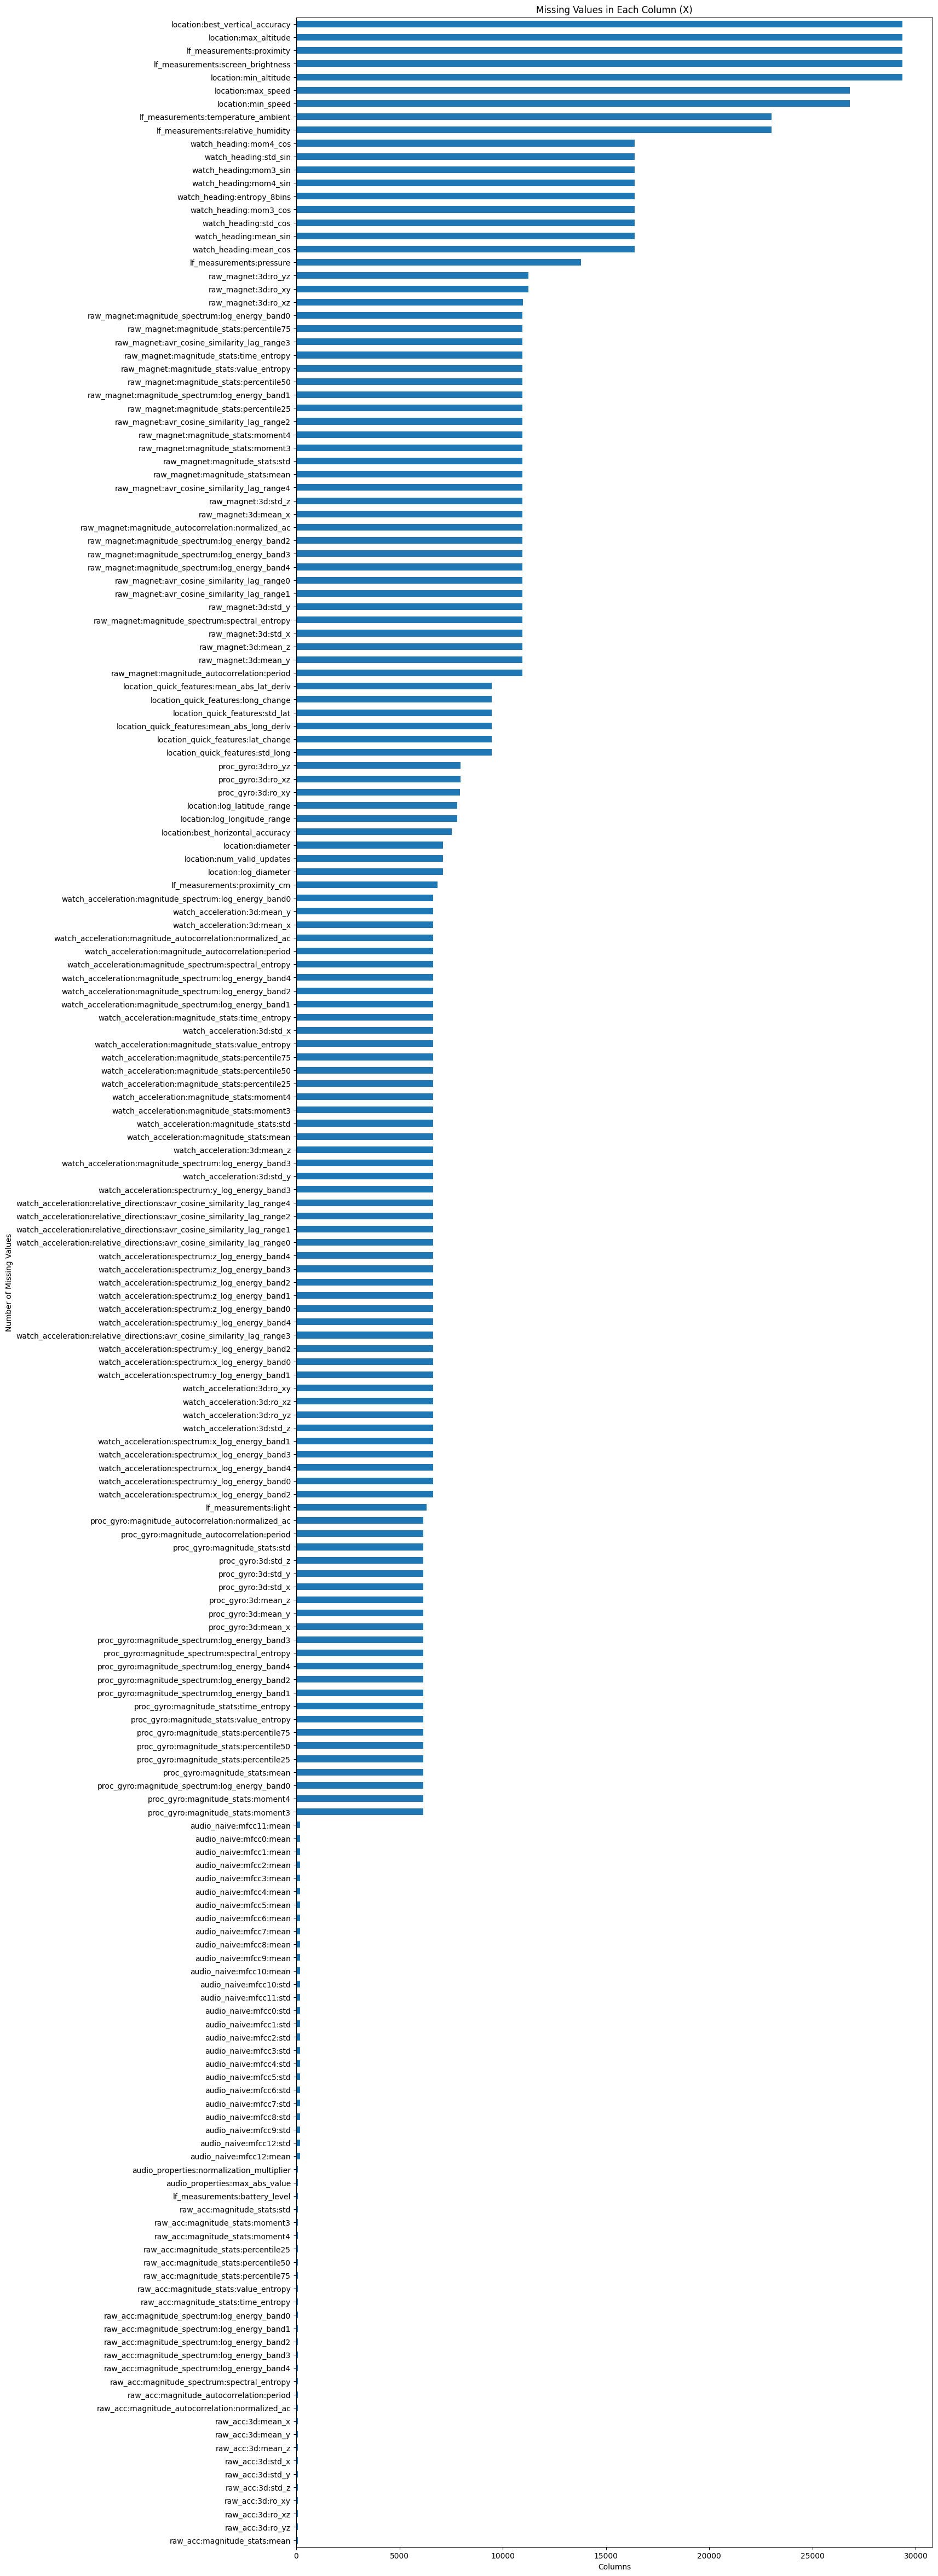

/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_4080/2398456764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(-1, inplace=True)


In [13]:
missing_value_check(X, 'X')
X.fillna(-1, inplace=True)
#TODO: Need to find the best way to add the missing values

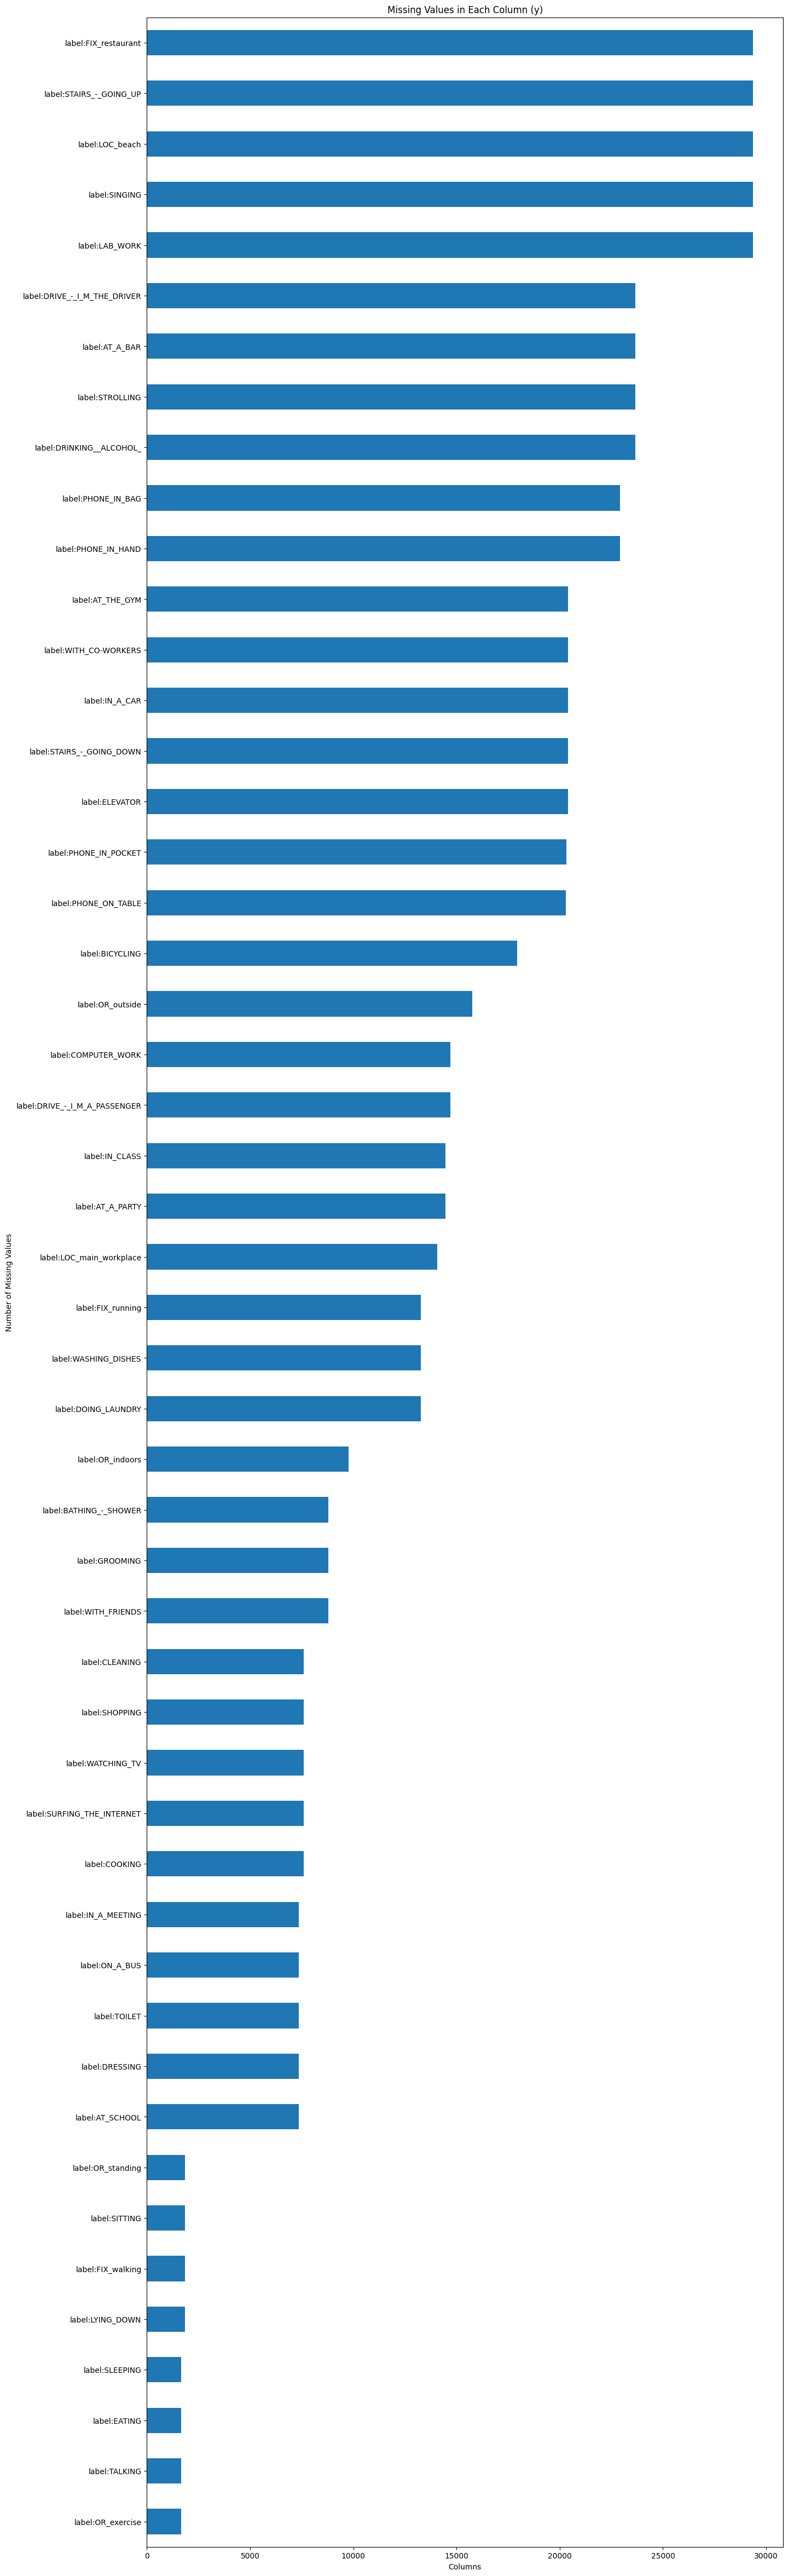

All the missing values have been covered.


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_4080/1312125286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


In [14]:
missing_value_check(y, 'y')
y.fillna(0, inplace=True)
missing_value_check(y, 'y')

## Model Testing


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
import tensorflow as tf


model = tf.keras.Sequential([
    tf.keras.Input(shape=(len(input_columns),)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(output_columns))]
)

In [17]:
model.compile(optimizer='adam', loss='mse')

#### JUST AN IMAGE
Only need few epochs:

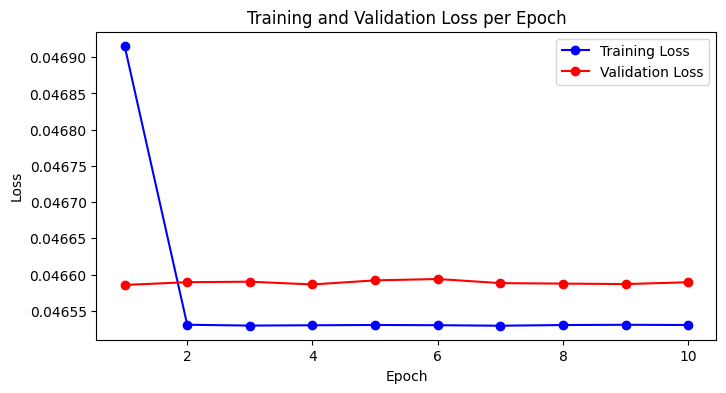
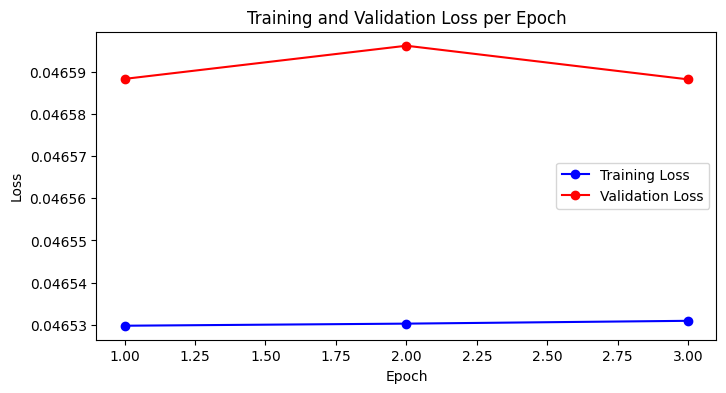

In [18]:
epochs = 3
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/3
514/514 [==============================] - 10s 18ms/step - loss: 265207989403648.0000 - val_loss: 16220.5537
Epoch 2/3
514/514 [==============================] - 2s 5ms/step - loss: 16198.3203 - val_loss: 15281.2402
Epoch 3/3
514/514 [==============================] - 2s 5ms/step - loss: 493791648.0000 - val_loss: 82575944.0000


In [19]:
# Save the entire model to a file
model.save("tf_model_v2.h5")

/Users/zaina/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
print(y_test[1:3])
y_pred_0 = model.predict(X_test[1:3])
print(y_pred_0)

      label:LYING_DOWN  label:SITTING  label:FIX_walking  label:FIX_running  \
4209               1.0            0.0                0.0                0.0   
3455               0.0            0.0                0.0                0.0   

      label:BICYCLING  label:SLEEPING  label:LAB_WORK  label:IN_CLASS  \
4209              0.0             1.0             0.0             0.0   
3455              1.0             0.0             0.0             0.0   

      label:IN_A_MEETING  label:LOC_main_workplace  label:OR_indoors  \
4209                 0.0                       0.0               1.0   
3455                 0.0                       0.0               0.0   

      label:OR_outside  label:IN_A_CAR  label:ON_A_BUS  \
4209               0.0             0.0             0.0   
3455               0.0             0.0             0.0   

      label:DRIVE_-_I_M_THE_DRIVER  label:DRIVE_-_I_M_A_PASSENGER  \
4209                           0.0                            0.0   
3455        

In [21]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

# Predictions
y_pred = model.predict(X_test)


276/276 [==============================] - 1s 4ms/step - loss: 82582624.0000
Test Loss: 82582624.0000
276/276 [==============================] - 1s 2ms/step


In [22]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (8806, 226)
y_test shape: (8806, 51)


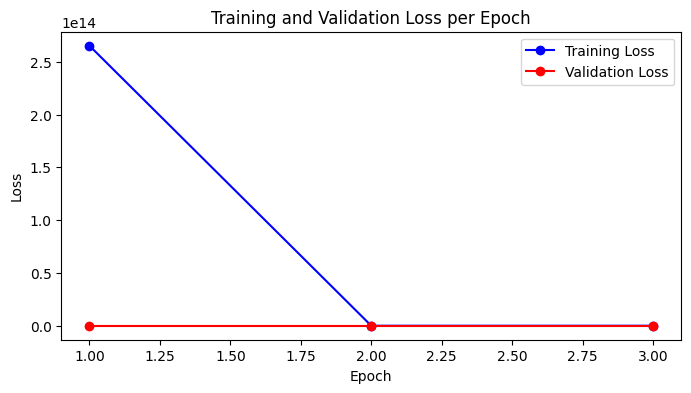

In [23]:
# Extracting loss and validation loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Creating epoch numbers (starting from 1)
epochs_range = range(1, epochs + 1)

# Plotting the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [24]:
!pip3 freeze > requirements.txt

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Assuming combined_csv_data is your DataFrame and it has been loaded already



# Before splitting, ensure there are no NaN values in your output columns
for col in output_columns:
    combined_csv_data[col].fillna(0, inplace=True)  # Replace NaN in y with 0, if appropriate

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_csv_data[input_columns], combined_csv_data[output_columns], test_size=0.2, random_state=42)

predictions = {}

for output_col in output_columns:
    # Create a pipeline with an imputer (to fill missing values in features) and logistic regression
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Fills missing X values with the mean of each column
        LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence
    )
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train[output_col])
    
    # New data for prediction. This example is simplified and should be replaced with actual new data.
    # Ensure X_new has the same number of features as X_train. Here, we use np.nan as placeholders.
    X_new = np.array([[0.5, 1.2] + [np.nan] * (224)])  # Adjusted to match the feature count of the trained model
    
    # Predicting the probability for the given X_new
    pred_prob = pipeline.predict_proba(X_new)[0][1]
    
    # Storing the prediction
    predictions[output_col] = pred_prob

# Displaying the predicted probabilities
for y_col, prob in predictions.items():
    print(f"Predicted probability for {y_col}: {prob:.2%}")


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_4080/3046016783.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_csv_data[col].fillna(0, inplace=True)  # Replace NaN in y with 0, if appropriate
/Users/zaina/miniconda3/lib/python3.10/site-packages/sklearn/impute/_base.py:565: UserWarning: Skipping features without any observed values: ['location:min_altitude' 'location:max_altitude'
 'location:best_vertical_accuracy' 'lf_measurements:proximity'
 'lf_measurements:screen_brightness']. At least one non-miss

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

In [ ]:
len(predictions)

51

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import warnings


warnings.filterwarnings("ignore", message="X does not have valid feature names, but SimpleImputer was fitted with feature names")

# Assuming combined_csv_data is your DataFrame and it has been loaded already
# Replace 'combined_csv_data' with the actual variable name of your DataFrame

# Fill missing values in output columns with a default value (e.g., 0)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store the pipeline for each output column
pipelines = {}

# Train a pipeline for each output column
for output_col in output_columns:
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Impute missing values
        LogisticRegression(max_iter=1000)  # Logistic regression
    )
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train[output_col])
    pipelines[output_col] = pipeline

# Predicting the probabilities for each row in X_test
predictions = {col: [] for col in output_columns}  # Initialize dictionary to store predictions

for index, row in X_test.iterrows():
    for output_col in output_columns:
        # Predict the probability for the current row and output column
        pred_prob = pipelines[output_col].predict_proba(row.values.reshape(1, -1))[0][1]
        predictions[output_col].append(pred_prob)

# Optionally, print out the predicted probabilities for the first few rows of X_test
for i, (index, row) in enumerate(X_test.iterrows()):
    if i >= 5:  # Limit output to first 5 rows
        break
    print(f"Predictions for row {index}:")
    for output_col in output_columns:
        print(f"  {output_col}: {predictions[output_col][i]:.2%}")
    print()  # Newline for readability


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_43744/1352247473.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


Predictions for row 225548:
  label:LYING_DOWN: 45.00%
  label:SITTING: 36.16%
  label:FIX_walking: 2.10%
  label:FIX_running: 0.29%
  label:BICYCLING: 0.49%
  label:SLEEPING: 22.02%
  label:LAB_WORK: 0.57%
  label:IN_CLASS: 1.63%
  label:IN_A_MEETING: 1.36%
  label:LOC_main_workplace: 9.00%
  label:OR_indoors: 63.17%
  label:OR_outside: 3.21%
  label:IN_A_CAR: 0.65%
  label:ON_A_BUS: 0.47%
  label:DRIVE_-_I_M_THE_DRIVER: 2.12%
  label:DRIVE_-_I_M_A_PASSENGER: 0.67%
  label:LOC_home: 49.30%
  label:FIX_restaurant: 0.55%
  label:PHONE_IN_POCKET: 6.24%
  label:OR_exercise: 0.83%
  label:COOKING: 1.06%
  label:SHOPPING: 0.49%
  label:STROLLING: 0.21%
  label:DRINKING__ALCOHOL_: 0.39%
  label:BATHING_-_SHOWER: 0.55%
  label:CLEANING: 1.02%
  label:DOING_LAUNDRY: 0.15%
  label:WASHING_DISHES: 0.33%
  label:WATCHING_TV: 3.51%
  label:SURFING_THE_INTERNET: 5.18%
  label:AT_A_PARTY: 0.39%
  label:AT_A_BAR: 0.15%
  label:LOC_beach: 0.09%
  label:SINGING: 0.17%
  label:TALKING: 9.61%
  label:COM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import warnings


warnings.filterwarnings("ignore", message="X does not have valid feature names, but SimpleImputer was fitted with feature names")

# Assuming combined_csv_data is your DataFrame and it has been loaded already
# Replace 'combined_csv_data' with the actual variable name of your DataFrame

# Fill missing values in output columns with a default value (e.g., 0)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store the pipeline for each output column
pipelines = {}

# Train a pipeline for each output column
for output_col in output_columns:
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Impute missing values
        LogisticRegression(max_iter=1000)  # Logistic regression
    )
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train[output_col])
    pipelines[output_col] = pipeline

# Predicting the probabilities for each row in X_test
predictions = {col: [] for col in output_columns}  # Initialize dictionary to store predictions

for index, row in X_test.iterrows():
    for output_col in output_columns:
        # Predict the probability for the current row and output column
        pred_prob = pipelines[output_col].predict_proba(row.values.reshape(1, -1))[0][1]
        predictions[output_col].append(pred_prob)

# Optionally, print out the predicted probabilities for the first few rows of X_test
for i, (index, row) in enumerate(X_test.iterrows()):
    if i >= 5:  # Limit output to first 5 rows
        break
    print(f"Predictions for row {index}:")
    for output_col in output_columns:
        print(f"  {output_col}: {predictions[output_col][i]:.2%}")
    print()  # Newline for readability


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_43744/1352247473.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


KeyboardInterrupt: 

In [ ]:
combined_csv_data.head()

NameError: name 'combined_csv_data' is not defined

In [ ]:
import pandas as pd
import numpy as np
from threading import Timer

class Phone:
    def __init__(self, data_df):
        self.data_df = data_df  # Assume data_df is a DataFrame loaded with user data

    def collect_data(self, userid):
        """Collects a random data row for a given user."""
        user_data = self.data_df[self.data_df['user_id'] == userid].sample(n=1)
        return user_data

    def process_data(self, userid, model):
        """Processes data using a specified model."""
        data = self.collect_data(userid)
        # Assuming `model` is a function passed to process the data
        processed_data = model(data)
        return processed_data

    def send_data(self, userid, interval, server):
        """Periodically sends data at specified intervals."""
        data = self.collect_data(userid)
        server.store_update_data(data)
        Timer(interval, self.send_data, args=[userid, interval, server]).start()

class Server:
    def __init__(self):
        self.storage_df = pd.DataFrame()  # Separate DataFrame for storing data

    def request_data(self, phone, userid, raw=True):
        """Requests data from the Phone class."""
        if raw:
            return phone.collect_data(userid)
        else:
            return phone.process_data(userid, self.process_data)  # Example: self.process_data as a placeholder

    def process_data(self, data):
        """Processes data."""
        # This is a placeholder for data processing logic, which could involve ML models or other transformations
        processed_data = data  # Simplified for demonstration
        return processed_data

    def store_update_data(self, data):
        """Stores or updates data in a separate DataFrame."""
        self.storage_df = pd.concat([self.storage_df, data], ignore_index=True)




In [ ]:
data_df = pd.read_csv('ExtraSensory_Combined_User_Data.csv')

In [ ]:
phone = Phone(data_df)
server = Server()

In [ ]:
userid="81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0"
raw_data = server.request_data(phone, userid, raw=True)
processed_data = server.request_data(phone, userid, raw=False)
server.store_update_data(raw_data)
server.store_update_data(processed_data)

In [ ]:
# df = X and y

# Format data into our stuture after predition

# Tablaue

# User - Dynamic
    # User Activity against timestamps
    # Porbablity Related - Select User and Time  (Log Reg) Probablities

In [ ]:
server.storage_df

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source,user_id
0,1446541934,1.020442,0.001224,-0.000816,0.001642,1.019684,1.020508,1.021267,2.513081,6.684611,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0
1,1446295467,1.035055,0.004175,0.003772,0.005590,1.032436,1.034281,1.036872,2.462429,6.684604,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0


In [ ]:
data_df.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source,user_id
0,1446141691,1.009726,0.002838,-0.002296,0.005568,1.008208,1.009735,1.011174,1.572784,6.684608,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0
1,1446141752,1.009822,0.004624,0.003040,0.008459,1.007704,1.009619,1.011857,1.754729,6.684601,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0
2,1446141805,1.009667,0.004781,-0.007802,0.014457,1.008038,1.009772,1.011139,1.012852,6.684600,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0
3,1446141873,1.008839,0.003543,0.001831,0.007082,1.007134,1.008803,1.010433,1.511878,6.684606,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0
4,1446141925,1.008193,0.001753,-0.000744,0.002439,1.007142,1.008234,1.009350,2.347186,6.684610,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0


In [51]:
len(combined_csv_data)

377346

In [50]:
nan_count_full = combined_csv_data[features].isna().sum()
nan_count_sorted_full = nan_count.sort_values(ascending=False)
nan_count_sorted_full


lf_measurements:proximity                                                  6407
location:best_vertical_accuracy                                            6407
location:max_altitude                                                      6407
location:min_altitude                                                      6407
lf_measurements:screen_brightness                                          6407
watch_heading:std_sin                                                       228
watch_heading:mean_sin                                                      228
watch_heading:mom4_cos                                                      228
watch_heading:mom3_cos                                                      228
watch_heading:std_cos                                                       228
watch_heading:mean_cos                                                      228
watch_heading:mom3_sin                                                      228
watch_heading:mom4_sin                  

In [36]:
hierarchy = build_hierarchy(X.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

- raw_acc:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  mean_y
    -  mean_z
    -  std_x
    -  std_y
    -  std_z
    -  ro_xy
    -  ro_xz
    -  ro_yz
- proc_gyro:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  m